In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
true_df = pd.read_csv("True.csv")
true_df = true_df.drop(['subject','date'],axis=1)
true_df.head()

,title,text
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...


In [3]:
fake_df = pd.read_csv('Fake.csv')
fake_df = fake_df.drop(['subject','date'],axis=1)
fake_df.head()

,title,text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...


In [4]:
len(true_df), len(fake_df)

(21417, 23481)

In [5]:
true_df['target'] = [1 for target in range(len(true_df))]
fake_df['target'] = [0 for target in range(len(fake_df))]
true_df.head()

,title,text,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [6]:
fake_df.head()

,title,text,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0


In [7]:
dataframes = [true_df, fake_df]
news_df = pd.concat(dataframes, keys=['x','y','z'])

In [8]:
news_df = news_df.sample(frac=1, random_state=42)
news_df.head()

title  \
y 799     BREAKING: GOP Chairman Grassley Has Had Enoug...   
  6500    Failed GOP Candidates Remembered In Hilarious...   
  3590    Mike Pence’s New DC Neighbors Are HILARIOUSLY...   
x 1377   California AG pledges to defend birth control ...   
y 11059  AZ RANCHERS Living On US-Mexico Border Destroy...   

                                                      text  target  
y 799    Donald Trump s White House is in chaos, and th...       0  
  6500   Now that Donald Trump is the presumptive GOP n...       0  
  3590   Mike Pence is a huge homophobe. He supports ex...       0  
x 1377   SAN FRANCISCO (Reuters) - California Attorney ...       1  
y 11059  Twisted reasoning is all that comes from Pelos...       0

In [9]:
from numpy.random import RandomState

rng = RandomState()

train_df = news_df.sample(frac=0.7, random_state=rng)
val_df = news_df.loc[~news_df.index.isin(train_df.index)]

In [10]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()

len(train_sentences), len(val_sentences)

(31429, 13469)

In [11]:
train_sentences[:10]

['Congress will vote on a new spending bill in just a few days so they d better get crackin  so they can read the 2,009 page bill before they vote on it, right? You can bet that when the vote comes on this bad deal that most of those voting on it have no idea what s in it. It s a typical pork-filled spending bill that throws the American taxpayer under the bus. The Republicans caved on letting Obama send 10,000 Syrian refugees for the taxpayers to support. Republicans are spineless sellouts The new spending deal reached early Wednesday morning spans more than 2,000 pages, spends $1.149 trillion   and lawmakers will have only a few days to digest it all before they re asked to vote on the legislation, which lays out Congress s priorities for the rest of fiscal year 2016.It works out to nearly $572 million per page, with lawmakers splashing money throughout the government, boosting both popular and unpopular programs alike, thanks to a spending hike agreed to in October s budget deal. Th

In [27]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))


In [12]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())

train_labels_encoded

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(
    train_sentences,
    train_labels_encoded
)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [14]:
model_0.score(val_sentences, val_labels_encoded)

0.9354072314202985

In [15]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [16]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    model_accuracy = accuracy_score(y_true, y_pred)*100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1-score": model_f1}
    return model_results

In [17]:
baseline_results = calculate_results(val_labels_encoded, baseline_preds)
baseline_results

{'accuracy': 93.54072314202985,
 'precision': 0.9354501480982574,
 'recall': 0.9354072314202985,
 'f1-score': 0.9353789712573514}

In [18]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = np.round(np.mean(sent_lens))
avg_sent_lens

404.0

(array([2.4466e+04, 6.1310e+03, 5.8200e+02, 1.1800e+02, 4.6000e+01,
        2.7000e+01, 2.0000e+01, 1.9000e+01, 5.0000e+00, 2.0000e+00,
        5.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00, 3.0000e+00]),
 array([   0.        ,  542.33333333, 1084.66666667, 1627.        ,
        2169.33333333, 2711.66666667, 3254.        , 3796.33333333,
        4338.66666667, 4881.        , 5423.33333333, 5965.66666667,
        6508.        , 7050.33333333, 7592.66666667, 8135.        ]),
 <BarContainer object of 15 artists>)

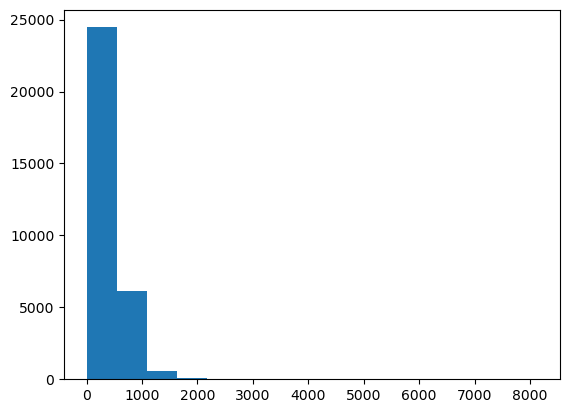

In [19]:
plt.hist(sent_lens, bins=15)

In [20]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

900

In [21]:
max_tokens = 68000

text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens = max_tokens,
    output_sequence_length = output_seq_len,
    pad_to_max_tokens=True
)

text_vectorizer.adapt(train_sentences)

In [22]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n {target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
 BERLIN (Reuters) - Angela Merkel s conservatives maintained a strong lead over their rival Social Democrats (SPD), who lost ground slightly, in a poll published on Thursday, three days before an election the German chancellor is set to win. The Forschungsgruppe Wahlen poll for broadcaster ZDF showed Merkel s CDU/CSU bloc was unchanged on 36 percent while the SPD dropped by 1.5 points to 21.5 percent. The anti-immigrant Alternative for Germany (AfD), which is expected to become the first far-right party in parliament for more than half a century, looked set to come third with 11 percent - one point more than last week. The pro-business Free Democrats were on 10 percent, followed by the radical Left on 8.5 percent and the Greens on 8 percent. That would present as potential alliance options a  grand coalition  between Merkel s conservatives and the SPD, or a three-way  Jamaica  alliance of the conservatives, FDP and Greens - so named because the colours of the parties match those 

In [24]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 900,
 'pad_to_max_tokens': True}

In [25]:
token_embed = tf.keras.layers.Embedding(
    input_dim = 68000,
    output_dim = 128,
    mask_zero = True,
    name='token_embedding'
)

In [26]:
import random
target_sentence = random.choice(train_sentences)

print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
print(f"Vectorized sentence shape: {vectorized_sentence.shape}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 NIZHNY NOVGOROD/MOSCOW (Reuters) - President Vladimir Putin confirmed Russia s worst kept political secret on Wednesday, saying he would run for re-election in March 2018 - a contest he seems sure to win comfortably and extend his grip on power into a third decade. Putin, 65, has been in power, either as president or prime minister, since 2000, longer than veteran Soviet leader Leonid Brezhnev and outstripped only by dictator Josef Stalin. If he wins what would be a fourth presidential term, he will be eligible to serve another six years until 2024, when he turns 72. Backed by state TV, Putin regularly enjoys approval ratings of around 80 percent, and his decision to run for re-election   which he announced at a car-making factory in the Volga river city of Nizhny Novgorod   was widely expected.     I will put forward my candidacy for the post of president of the Russian Federation,  Putin said, in answer to a question from a factory worker who told the 

In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))


In [29]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [34]:
#Model-1
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(64, 5, activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(2, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs, name='model_1_Conv1D_Token')

model_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [35]:
model_1.summary()

Model: "model_1_Conv1D_Token"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 900)               0         
_________________________________________________________________
token_embedding (Embedding)  (None, 900, 128)          8704000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 896, 64)           41024     
_________________________________________________________________
global_average_pooling1d_2 ( (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 8,745,154
Trainable params: 8,745,154
Non-trainable params: 0
____________________________________

In [36]:
model_1_history = model_1.fit(
    train_dataset,
    steps_per_epoch=int(0.1 * len(train_dataset)),
    epochs=5,
    validation_data=val_dataset,
    validation_steps=int(0.1 * len(val_dataset))
)

Epoch 1/5
98/98 [==============================] - 20s 63ms/step - loss: 0.5163 - accuracy: 0.7873 - val_loss: 0.2363 - val_accuracy: 0.9234
Epoch 2/5
98/98 [==============================] - 6s 57ms/step - loss: 0.1452 - accuracy: 0.9633 - val_loss: 0.1243 - val_accuracy: 0.9673
Epoch 3/5
98/98 [==============================] - 4s 39ms/step - loss: 0.0846 - accuracy: 0.9815 - val_loss: 0.1117 - val_accuracy: 0.9747
Epoch 4/5
98/98 [==============================] - 4s 39ms/step - loss: 0.0778 - accuracy: 0.9850 - val_loss: 0.0809 - val_accuracy: 0.9851
Epoch 5/5
98/98 [==============================] - 4s 45ms/step - loss: 0.0701 - accuracy: 0.9857 - val_loss: 0.0700 - val_accuracy: 0.9881


In [37]:
model_1.evaluate(val_dataset)

421/421 [==============================] - 6s 14ms/step - loss: 0.0594 - accuracy: 0.9907


[0.05936324968934059, 0.9907194375991821]

In [38]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

array([[4.8114368e-01, 5.1885635e-01],
       [5.2351934e-01, 4.7648069e-01],
       [4.1090841e-03, 9.9589086e-01],
       ...,
       [1.6395270e-05, 9.9998355e-01],
       [9.9999917e-01, 8.3501351e-07],
       [9.9327764e-04, 9.9900669e-01]], dtype=float32)

In [39]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(13469,), dtype=int64, numpy=array([1, 0, 1, ..., 1, 0, 1], dtype=int64)>

In [40]:
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 99.0719429801767,
 'precision': 0.9907215424486643,
 'recall': 0.990719429801767,
 'f1-score': 0.9907198236418997}

In [41]:
baseline_results

{'accuracy': 93.54072314202985,
 'precision': 0.9354501480982574,
 'recall': 0.9354072314202985,
 'f1-score': 0.9353789712573514}